In [132]:
import pandas as pd
import numpy as np
import random
import numpy
from matplotlib import pyplot as plt
import seaborn 
from IPython import display

In [186]:
accounts_df = pd.read_csv('clean_account.csv', sep=',')
cards_df = pd.read_csv('clean_card.csv', sep=',')
clients_df = pd.read_csv('clean_client.csv', sep=',')
dispos_df = pd.read_csv('clean_disp.csv', sep=',')
district_df = pd.read_csv('clean_district.csv', sep=',')
loan_df = pd.read_csv('clean_loan.csv', sep=',')
order_df = pd.read_csv('clean_order.csv', sep=',')
trans_df = pd.read_csv('clean_trans.csv', sep=',', engine='python')

Relation "**client**" describes characteristics of persons who can manipulate with the accounts. More clients can manipulate with single account; clients and accounts are related together in relation "**disposition**". 

Each account has both static characteristics (e.g. date of creation, address of the branch) given in relation "**account**" and dynamic characteristics (e.g. payments debited or credited, balances) given in relations "**permanent order**" and "**transaction**". 


Relations "**loan**" and "**credit card**" describe some services which the bank offers to its clients; more credit cards can be issued to an account, at most one loan can be granted for an account. 

Relation "**demographic data**" gives some publicly available information about the districts (e.g. the unemployment rate); additional information about the clients can be deduced from this.

# **Client**

**Number of Account/Client, Number of Client/Account**

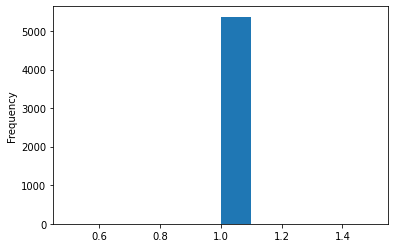

In [9]:
# All the Client only has one account
num_acc_each_user = dispos_df.groupby(['client_id'])['account_id'].count()
num_acc_each_user.plot.hist()

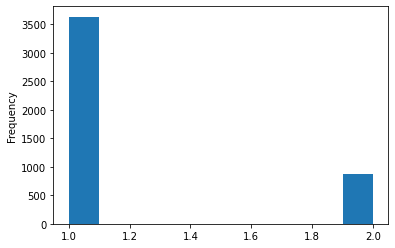

In [8]:
# Most of the account has either one or two users  
num_user_each_acc = dispos_df.groupby(['account_id'])['client_id'].count()
num_user_each_acc.plot.hist()

In [65]:
print(f'There are {num_user_each_acc.count()} accounts in total')

There are 4500 accounts in total


In [71]:
one_user = num_user_each_acc.loc[num_user_each_acc == 1].count()
two_user = num_user_each_acc.loc[num_user_each_acc == 2].count()
one_user_ratio = round((one_user/(one_user + two_user) * 100), 2)
two_user_ratio = round(100 - one_user_ratio, 2)
print(f'Check again that we have {one_user + two_user} accounts')
print(f'{one_user_ratio}% of them have one account, {two_user_ratio}% have two users')

Check again that we have 4500 accounts
80.69% of them have one account, 19.31% have two users


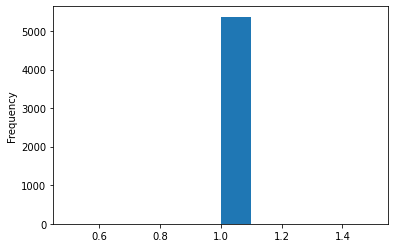

In [7]:
num_user_each_acc = dispos_df.groupby(['client_id'])['account_id'].count()
num_user_each_acc.plot.hist()

**Client Age Distribution**

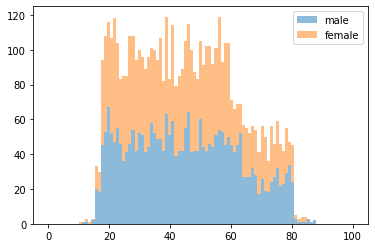

In [26]:
clients_df_male = clients_df.loc[clients_df['gender'] != 1]
clients_df_female = clients_df.loc[clients_df['gender'] != 0]

bins = numpy.linspace(0, 100, 100)

plt.hist(np.array([clients_df_female['age'], clients_df_male['age']], dtype=object), 
         label=['male', 'female'], bins=bins, alpha=0.5, stacked=True)
plt.legend(loc='upper right')
plt.show()

In [17]:
clients_df

,client_id,district_id,birth_date,gender,age
0,1,18,1970-12-13,0.0,28
1,2,1,1945-02-04,1.0,53
2,3,1,1940-10-09,0.0,58
3,4,5,1956-12-01,1.0,42
4,5,5,1960-07-03,0.0,38
...,...,...,...,...,...
5364,13955,1,1945-10-30,0.0,53
5365,13956,1,1943-04-06,1.0,55
5366,13968,61,1968-04-13,1.0,30
5367,13971,67,1962-10-19,0.0,36


In [20]:
# join customer info with district info   
clients_df_copy = clients_df.copy()
clients_dist_df = clients_df_copy.merge(district_df, left_on='district_id', 
                              right_on='district_identifier', how='left', 
                              validate='many_to_one') 
clients_dist_df.head()

,client_id,district_id,birth_date,gender,age,district_identifier,district_name,region_name,inhabitants_number,number_of_municipalities_with_<499_inhabitants,number_of_municipalities_with_500-1499_inhabitants,number_of_municipalities_with_2000-9999_inhabitants,number_of_municipalities_with_>10000_inhabitants,city_number,urban_inhabitants_ratio,average salary,1995_unemployment_rate,1996_unemployment_rate,entrepreneurs_per_1000_inhabitants,crimes_committed_number_in_1995,crimes_committed_number_in_1996
0,1,18,1970-12-13,0.0,28,18,Pisek,south Bohemia,70699,60,13,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
1,2,1,1945-02-04,1.0,53,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
2,3,1,1940-10-09,0.0,58,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
3,4,5,1956-12-01,1.0,42,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
4,5,5,1960-07-03,0.0,38,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [61]:
# count the number of clients per district
agg_dict = {'district_name': 'count',
            'age': 'median'}
district_clients_df = pd.DataFrame(clients_dist_df.groupby(
                                      ['district_name',
                                       'inhabitants_number', 
                                       'average salary',
                                       'urban_inhabitants_ratio'],
                                       axis=0).agg(agg_dict))
district_clients_df.columns = ['count', 'median_age']
district_clients_df.reset_index(inplace=True)

# calculating ratio of clients in the population of a district
district_clients_df ['client_ratio'] = (district_clients_df['count']/district_clients_df['inhabitants_number'])*100

In [62]:
district_clients_df.head()

,district_name,inhabitants_number,average salary,urban_inhabitants_ratio,count,median_age,client_ratio
0,Benesov,88884,8507,46.7,46,39.5,0.051753
1,Beroun,75232,8980,41.7,63,42.0,0.083741
2,Blansko,107911,8240,50.9,57,38.0,0.052821
3,Breclav,124605,8772,46.0,54,40.5,0.043337
4,Brno - mesto,387570,9897,100.0,155,41.0,0.039993


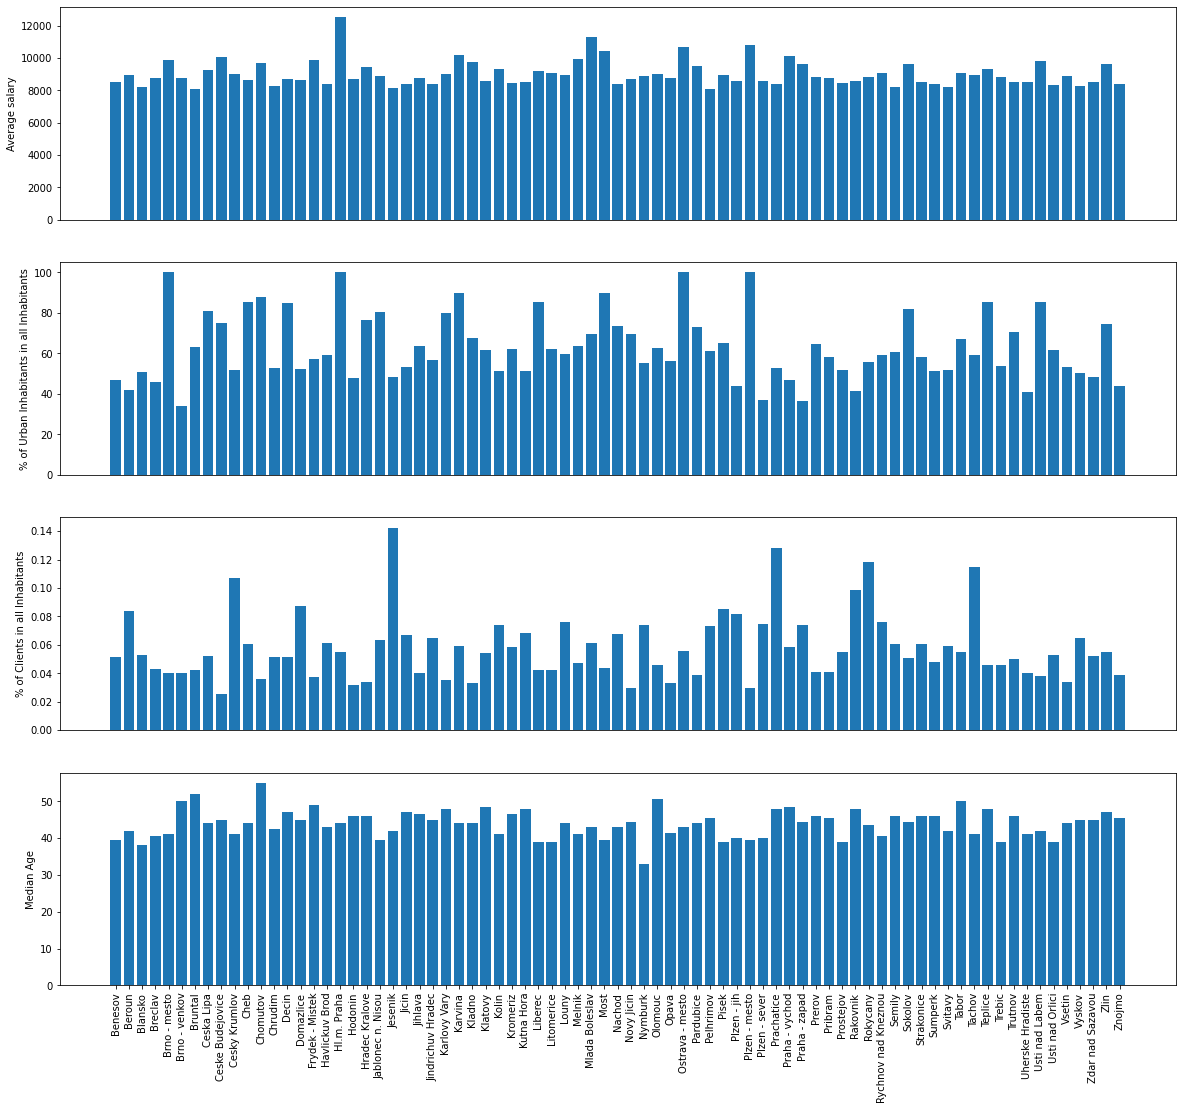

In [63]:
plt.figure(figsize=(20, 18))
x = range(len(district_clients_df['district_name']))

# locate the Average salary plot
plt.subplot(4,1,1)

avg_sal = plt.bar(x, district_clients_df['average salary'])
plt.ylabel('Average salary')
plt.xticks([],[])

# locate the urban_inhabitants_ratio plot
plt.subplot(4,1,2)

urb_ratio =plt.bar(x, district_clients_df['urban_inhabitants_ratio'])
plt.ylabel('% of Urban Inhabitants in all Inhabitants')
plt.xticks([],[])

# locate the client_ratio plot
plt.subplot(4,1,3)

pop_ratio =plt.bar(x, district_clients_df['client_ratio'])
plt.ylabel('% of Clients in all Inhabitants')
plt.xticks([],[])

# locate the client_ratio plot
plt.subplot(4,1,4)

pop_ratio =plt.bar(x, district_clients_df['median_age'])
plt.ylabel('Median Age')
plt.xticks([],[])


plt.xticks(x, district_clients_df['district_name'], rotation='vertical')

plt.show()

# **Loan**

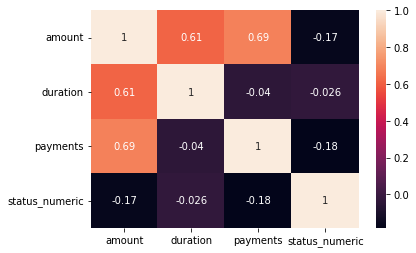

In [142]:
# Findings:
# 1. there's slight tendency that the higher the payment/loan amount, the easier 
#    loan to be in bad status
# 2. the higher amount is positively correlated with longer duration and more payments
#    which naturally makes sense

loan_df_copy = loan_df.copy()
loan_df_copy = loan_df_copy.drop(columns=['loan_id', 'account_id', 'date'])
seaborn.heatmap(loan_df_copy.corr(), annot=True)

# **Permanent Order** 

In [144]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    5092 non-null   object 
 6   purpose     5092 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 354.0+ KB


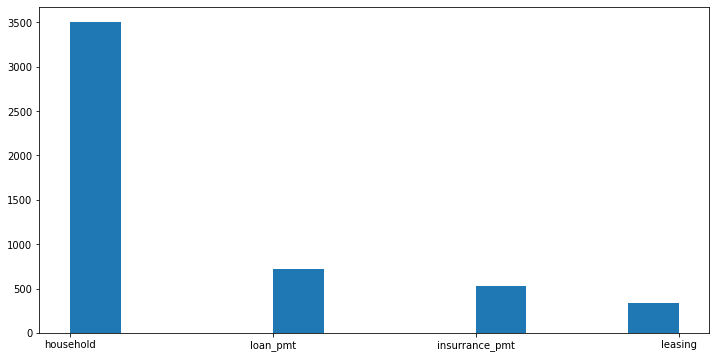

In [145]:
order_df.purpose.hist(figsize=(12, 6), bins=12, grid=False)

# **Transactions** 

In [102]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  object 
 3   type        1056320 non-null  object 
 4   operation   1056320 non-null  object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 80.6+ MB


In [106]:
trans_df

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,credit,deposit,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,credit,deposit,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,credit,deposit,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,credit,deposit,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,credit,deposit,400.0,400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1056315,3626622,2906,1998-12-31,credit,interest_pmt,62.3,13729.4,interest_pmt,NaN,NaN
1056316,3627616,2935,1998-12-31,credit,interest_pmt,81.3,19544.9,interest_pmt,NaN,NaN
1056317,3625403,2869,1998-12-31,credit,interest_pmt,60.2,14638.2,interest_pmt,NaN,NaN
1056318,3626683,2907,1998-12-31,credit,interest_pmt,107.5,23453.0,interest_pmt,NaN,NaN


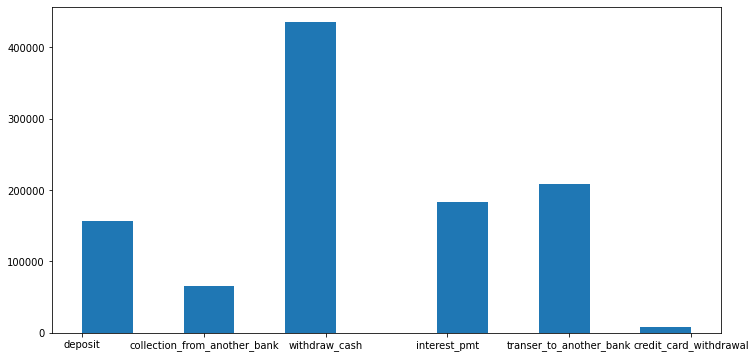

In [99]:
trans_df['operation'].hist(figsize=(12, 6), bins=12, grid=False)

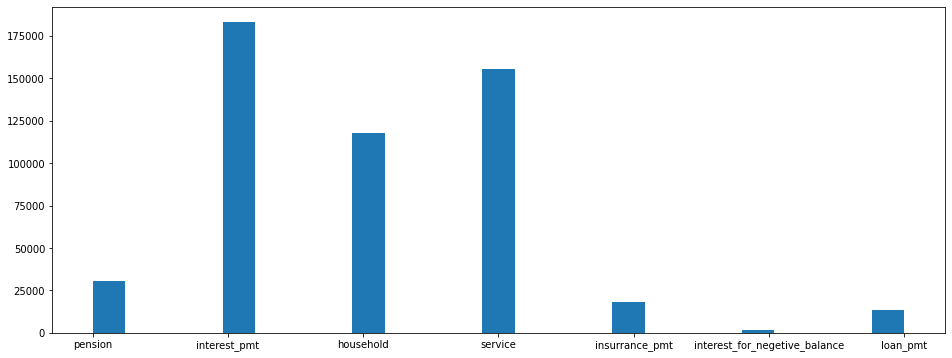

In [149]:
# the blank bar below represents the NaN values
trans_df['k_symbol'].hist(figsize=(16, 6), bins=25, grid=False)

## **Merge DataFrame contains Account Information**

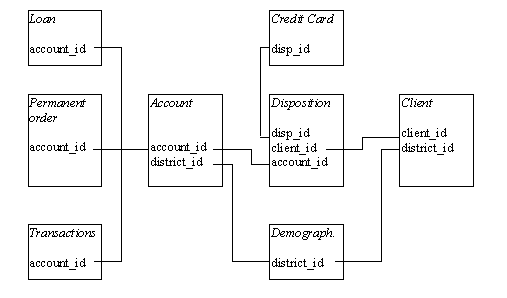

In [137]:
display.Image("data_map.png")

In [190]:
acc_to_merge = accounts_df.drop(columns=['date', 'district_id'])
clients_to_merge = clients_df.drop(columns=['birth_date'])

In [191]:
# merge Account, Disposition, Client and Demograph table
acc_disp = acc_to_merge.merge(dispos_df, on='account_id', how='left', 
                              validate='one_to_many') 
acc_disp_client = acc_disp.merge(clients_to_merge, on='client_id', how='left', 
                              validate='one_to_one')
acc_disp_client_demo = acc_disp_client.merge(district_df, on='district_id', how='left', 
                              validate='many_to_one')

In [225]:
acc_disp_client_demo.to_csv('client_info.csv', index=False)